In [9]:
import os
import tensorflow as tf
import math
import tensorflow.keras.backend as K
from collections import defaultdict
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

In [2]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
DATA_DIR = "/kaggle/input/openaimer-2025-track1/openaimer-2025-track1/OpenAImer2025_Image_Classification/OpenAImer/train"  # Replace this
CHANNELS=3
TRAIN_RATIO = 0.8

In [3]:
raw_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(HEIGHT, WIDTH),
    label_mode='int',
    batch_size=None  # Important for oversampling
)

# === GET CLASS DISTRIBUTION ===
class_counts = defaultdict(int)
for _, label in raw_ds:
    class_counts[int(label.numpy())] += 1

max_class_count = max(class_counts.values())
class_names = list(sorted(os.listdir(DATA_DIR)))

Found 3043 files belonging to 7 classes.


I0000 00:00:1744608728.682760      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    # if p_cutout > .5:
    #     image = data_augment_cutout(image)
        
    return image, label

In [5]:
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [6]:
x = 500  # Or any threshold you choose
balanced_ds_list = []

for class_idx in range(len(class_names)):
    class_ds = raw_ds.filter(lambda img, label: label == class_idx)
    
    if class_counts[class_idx] < x:
        repeat_factor = x // class_counts[class_idx] + 1
        class_ds = class_ds.repeat(repeat_factor).take(x)
    
    class_ds = class_ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
    balanced_ds_list.append(class_ds)

# Combine all class-wise datasets
balanced_ds = balanced_ds_list[0]
for ds in balanced_ds_list[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

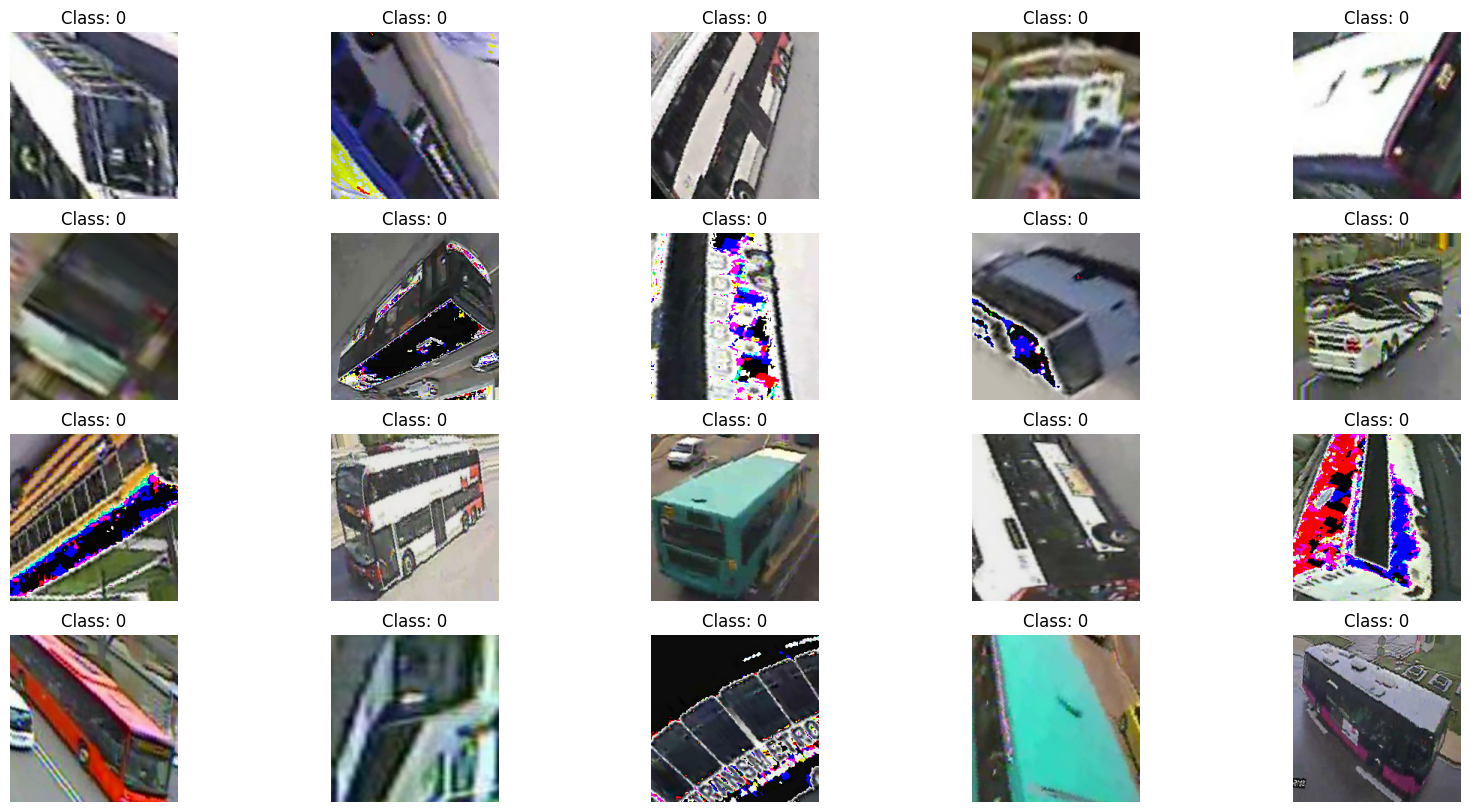

In [7]:
train_iter = balanced_ds.batch(20)
import matplotlib.pyplot as plt

# Fetch 20 images (1 batch if BATCH_SIZE >= 20)
for images, labels in train_iter.take(1):
    plt.figure(figsize=(20, 10))
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")
    break

In [8]:
balanced_ds = balanced_ds.shuffle(10000, seed=42, reshuffle_each_iteration=False)

# Count total number of samples
total_samples = 0
for _ in balanced_ds:
    total_samples += 1

# Split sizes
train_size = int(total_samples * TRAIN_RATIO)

# Split dataset
train_ds = balanced_ds.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = balanced_ds.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

3884

In [9]:
num_classes = len(class_names)
base_model = EfficientNetB0(include_top=False, input_shape=(HEIGHT, WIDTH, 3), weights='imagenet', pooling='avg')
base_model.trainable = True  # Freeze base model

inputs = tf.keras.Input(shape=(HEIGHT, WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# === COMPILE ===
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === SUMMARY ===
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,709,034 (17.96 MB)

 Trainable params: 4,667,011 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


I0000 00:00:1744554627.500842      98 service.cc:148] XLA service 0x78f4a8002f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744554627.501575      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744554632.385155      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744554640.963828      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744554641.150975      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744554641.615610      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744554641.8220

    140/Unknown 181s 109ms/step - accuracy: 0.7233 - loss: 0.7691

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 260s 682ms/step - accuracy: 0.7239 - loss: 0.7673 - val_accuracy: 0.8580 - val_loss: 0.4848
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 222s 653ms/step - accuracy: 0.8779 - loss: 0.3540 - val_accuracy: 0.8955 - val_loss: 0.3798
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 163s 653ms/step - accuracy: 0.9222 - loss: 0.2239 - val_accuracy: 0.9339 - val_loss: 0.2061
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 168s 657ms/step - accuracy: 0.9290 - loss: 0.2180 - val_accuracy: 0.9232 - val_loss: 0.2536
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 167s 648ms/step - accuracy: 0.9286 - loss: 0.1976 - val_accuracy: 0.9152 - val_loss: 0.2790
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 167s 658ms/step - accuracy: 0.9299 - loss: 0.2068 - val_accuracy: 0.9455 - val_loss: 0.1571
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 171s 664ms/step - accuracy: 0.9387 - loss: 0.1611 - val_accuracy: 0.9384 - val_loss: 0.1734
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 166s 654ms/step - accuracy: 0.9536 - loss: 0.14

In [16]:
IMAGE_FOLDER = "/kaggle/input/openaimer-2025-track1/openaimer-2025-track1/OpenAImer2025_Image_Classification/OpenAImer/test"    # Replace with your images folder path
OUTPUT_CSV = "predictions.csv"            # Output CSV file name

def preprocess_image(img_path, target_size=(HEIGHT, WIDTH)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# === PREDICTION FUNCTION ===
def predict_image(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_label = np.argmax(predictions, axis=1)[0]
    return predicted_label

# === GET IMAGE FILES ===
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')]
image_ids = []

# Create a list of IDs and predicted labels
predictions = []

for img_file in tqdm(image_files, desc="Processing images", unit="image"):
    # Extract ID from the image file name
    img_id = img_file.replace("YehKarkeDikhaao", "").replace(".jpg", "")
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # Get prediction
    predicted_label = predict_image(model, img_path)
    
    # Append result
    image_ids.append(img_id)
    predictions.append(predicted_label)

Processing images:   0%|          | 0/1401 [00:00<?, ?image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Processing images:   0%|          | 1/1401 [00:06<2:40:54,  6.90s/image]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   0%|          | 3/1401 [00:07<42:50,  1.84s/image]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   0%|          | 5/1401 [00:07<21:32,  1.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   0%|          | 7/1401 [00:07<13:03,  1.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing images:   1%|          | 9/1401 [00:07<08:47,  2.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   1%|          | 11/1401 [00:07<06:14,  3.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   1%|          | 13/1401 [00:07<04:40,  4.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   1%|          | 15/1401 [00:07<03:38,  6.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:   1%|          | 17/1401 [00:07<02:56,  7.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   1%|▏         | 19/1401 [00:08<02:29,  9.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   1%|▏         | 21/1401 [00:08<02:12, 10.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   2%|▏         | 23/1401 [00:08<02:02, 11.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   2%|▏         | 25/1401 [00:08<01:53, 12.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   2%|▏         | 27/1401 [00:08<01:57, 11.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   2%|▏         | 29/1401 [00:08<01:48, 12.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   2%|▏         | 31/1401 [00:08<01:42, 13.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   2%|▏         | 33/1401 [00:09<01:38, 13.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   2%|▏         | 35/1401 [00:09<01:36, 14.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   3%|▎         | 37/1401 [00:09<01:33, 14.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   3%|▎         | 39/1401 [00:09<01:32, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   3%|▎         | 41/1401 [00:09<01:32, 14.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   3%|▎         | 43/1401 [00:09<01:30, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:   3%|▎         | 45/1401 [00:09<01:29, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   3%|▎         | 47/1401 [00:10<01:29, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   3%|▎         | 49/1401 [00:10<01:28, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   4%|▎         | 51/1401 [00:10<01:28, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   4%|▍         | 53/1401 [00:10<01:27, 15.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:   4%|▍         | 55/1401 [00:10<01:28, 15.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   4%|▍         | 57/1401 [00:10<01:28, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   4%|▍         | 59/1401 [00:10<01:28, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   4%|▍         | 61/1401 [00:10<01:27, 15.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   4%|▍         | 63/1401 [00:11<01:27, 15.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   5%|▍         | 65/1401 [00:11<01:27, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   5%|▍         | 67/1401 [00:11<01:27, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   5%|▍         | 69/1401 [00:11<01:26, 15.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   5%|▌         | 71/1401 [00:11<01:27, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   5%|▌         | 73/1401 [00:11<01:27, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   5%|▌         | 75/1401 [00:11<01:27, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   5%|▌         | 77/1401 [00:11<01:27, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   6%|▌         | 79/1401 [00:12<01:27, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   6%|▌         | 81/1401 [00:12<01:26, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   6%|▌         | 83/1401 [00:12<01:27, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   6%|▌         | 85/1401 [00:12<01:26, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   6%|▌         | 87/1401 [00:12<01:27, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   6%|▋         | 89/1401 [00:12<01:26, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   6%|▋         | 91/1401 [00:12<01:27, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   7%|▋         | 93/1401 [00:13<01:26, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   7%|▋         | 95/1401 [00:13<01:27, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   7%|▋         | 97/1401 [00:13<01:27, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   7%|▋         | 99/1401 [00:13<01:26, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   7%|▋         | 101/1401 [00:13<01:25, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   7%|▋         | 103/1401 [00:13<01:25, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   7%|▋         | 105/1401 [00:13<01:24, 15.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   8%|▊         | 107/1401 [00:13<01:25, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   8%|▊         | 109/1401 [00:14<01:24, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   8%|▊         | 111/1401 [00:14<01:23, 15.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   8%|▊         | 113/1401 [00:14<01:24, 15.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   8%|▊         | 115/1401 [00:14<01:23, 15.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:   8%|▊         | 117/1401 [00:14<01:23, 15.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   8%|▊         | 119/1401 [00:14<01:24, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   9%|▊         | 121/1401 [00:14<01:24, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:   9%|▉         | 123/1401 [00:15<01:23, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   9%|▉         | 125/1401 [00:15<01:24, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   9%|▉         | 127/1401 [00:15<01:24, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:   9%|▉         | 129/1401 [00:15<01:25, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:   9%|▉         | 131/1401 [00:15<01:28, 14.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:   9%|▉         | 133/1401 [00:15<01:27, 14.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|▉         | 135/1401 [00:15<01:26, 14.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|▉         | 137/1401 [00:15<01:27, 14.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|▉         | 139/1401 [00:16<01:26, 14.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|█         | 141/1401 [00:16<01:24, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|█         | 143/1401 [00:16<01:24, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|█         | 145/1401 [00:16<01:22, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  10%|█         | 147/1401 [00:16<01:22, 15.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  11%|█         | 149/1401 [00:16<01:21, 15.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  11%|█         | 151/1401 [00:16<01:21, 15.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  11%|█         | 153/1401 [00:17<01:20, 15.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  11%|█         | 155/1401 [00:17<01:21, 15.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  11%|█         | 157/1401 [00:17<01:23, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing images:  11%|█▏        | 159/1401 [00:17<01:27, 14.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing images:  11%|█▏        | 161/1401 [00:17<01:34, 13.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  12%|█▏        | 163/1401 [00:17<01:36, 12.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  12%|█▏        | 165/1401 [00:17<01:36, 12.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  12%|█▏        | 167/1401 [00:18<01:37, 12.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  12%|█▏        | 169/1401 [00:18<01:34, 13.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  12%|█▏        | 171/1401 [00:18<01:31, 13.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  12%|█▏        | 173/1401 [00:18<01:29, 13.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  12%|█▏        | 175/1401 [00:18<01:27, 13.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  13%|█▎        | 177/1401 [00:18<01:25, 14.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 179/1401 [00:18<01:25, 14.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 181/1401 [00:19<01:23, 14.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 183/1401 [00:19<01:22, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 185/1401 [00:19<01:22, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 187/1401 [00:19<01:21, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  13%|█▎        | 189/1401 [00:19<01:20, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▎        | 191/1401 [00:19<01:21, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 193/1401 [00:19<01:20, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 195/1401 [00:19<01:20, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 197/1401 [00:20<01:19, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 199/1401 [00:20<01:18, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 201/1401 [00:20<01:18, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  14%|█▍        | 203/1401 [00:20<01:18, 15.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  15%|█▍        | 205/1401 [00:20<01:18, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  15%|█▍        | 207/1401 [00:20<01:19, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  15%|█▍        | 209/1401 [00:20<01:18, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  15%|█▌        | 211/1401 [00:21<01:18, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  15%|█▌        | 213/1401 [00:21<01:17, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  15%|█▌        | 215/1401 [00:22<03:42,  5.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  15%|█▌        | 217/1401 [00:22<03:02,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▌        | 219/1401 [00:22<02:30,  7.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▌        | 221/1401 [00:22<02:10,  9.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▌        | 223/1401 [00:22<01:54, 10.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▌        | 225/1401 [00:22<01:42, 11.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▌        | 227/1401 [00:22<01:35, 12.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▋        | 229/1401 [00:23<01:30, 13.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  16%|█▋        | 231/1401 [00:23<01:26, 13.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  17%|█▋        | 233/1401 [00:23<01:24, 13.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  17%|█▋        | 235/1401 [00:23<01:21, 14.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  17%|█▋        | 237/1401 [00:23<01:20, 14.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  17%|█▋        | 239/1401 [00:23<01:20, 14.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  17%|█▋        | 241/1401 [00:23<01:19, 14.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  17%|█▋        | 243/1401 [00:24<01:18, 14.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  17%|█▋        | 245/1401 [00:24<01:17, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 247/1401 [00:24<01:16, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 249/1401 [00:24<01:17, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 251/1401 [00:24<01:16, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 253/1401 [00:24<01:16, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 255/1401 [00:24<01:16, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 257/1401 [00:24<01:15, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  18%|█▊        | 259/1401 [00:25<01:15, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  19%|█▊        | 261/1401 [00:25<01:15, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  19%|█▉        | 263/1401 [00:25<01:15, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  19%|█▉        | 265/1401 [00:25<01:16, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  19%|█▉        | 267/1401 [00:25<01:15, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  19%|█▉        | 269/1401 [00:25<01:15, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  19%|█▉        | 271/1401 [00:25<01:14, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  19%|█▉        | 273/1401 [00:25<01:13, 15.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  20%|█▉        | 275/1401 [00:26<01:14, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  20%|█▉        | 277/1401 [00:26<01:14, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  20%|█▉        | 279/1401 [00:26<01:13, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  20%|██        | 281/1401 [00:26<01:14, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  20%|██        | 283/1401 [00:26<01:13, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  20%|██        | 285/1401 [00:26<01:13, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  20%|██        | 287/1401 [00:26<01:13, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  21%|██        | 289/1401 [00:27<01:13, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  21%|██        | 291/1401 [00:27<01:13, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  21%|██        | 293/1401 [00:27<01:18, 14.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  21%|██        | 295/1401 [00:27<01:20, 13.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  21%|██        | 297/1401 [00:27<01:17, 14.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  21%|██▏       | 299/1401 [00:27<01:16, 14.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  21%|██▏       | 301/1401 [00:27<01:16, 14.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  22%|██▏       | 303/1401 [00:28<01:15, 14.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  22%|██▏       | 305/1401 [00:28<01:14, 14.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  22%|██▏       | 307/1401 [00:28<01:15, 14.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  22%|██▏       | 309/1401 [00:28<01:13, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  22%|██▏       | 311/1401 [00:28<01:13, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  22%|██▏       | 313/1401 [00:28<01:15, 14.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  22%|██▏       | 315/1401 [00:28<01:13, 14.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  23%|██▎       | 317/1401 [00:28<01:13, 14.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  23%|██▎       | 319/1401 [00:29<01:13, 14.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  23%|██▎       | 321/1401 [00:29<01:11, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  23%|██▎       | 323/1401 [00:29<01:12, 14.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  23%|██▎       | 325/1401 [00:29<01:12, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  23%|██▎       | 327/1401 [00:29<01:12, 14.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  23%|██▎       | 329/1401 [00:29<01:12, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▎       | 331/1401 [00:29<01:11, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▍       | 333/1401 [00:30<01:10, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  24%|██▍       | 335/1401 [00:30<01:11, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▍       | 337/1401 [00:30<01:10, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▍       | 339/1401 [00:30<01:10, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▍       | 341/1401 [00:30<01:09, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  24%|██▍       | 343/1401 [00:30<01:13, 14.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  25%|██▍       | 345/1401 [00:30<01:12, 14.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  25%|██▍       | 347/1401 [00:31<01:12, 14.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  25%|██▍       | 349/1401 [00:31<01:12, 14.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  25%|██▌       | 351/1401 [00:31<01:11, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  25%|██▌       | 353/1401 [00:31<01:10, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  25%|██▌       | 355/1401 [00:31<01:09, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  25%|██▌       | 357/1401 [00:31<01:10, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  26%|██▌       | 359/1401 [00:31<01:09, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  26%|██▌       | 361/1401 [00:31<01:09, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  26%|██▌       | 363/1401 [00:32<01:09, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  26%|██▌       | 365/1401 [00:32<01:09, 14.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  26%|██▌       | 367/1401 [00:32<01:09, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  26%|██▋       | 369/1401 [00:32<01:09, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  26%|██▋       | 371/1401 [00:32<01:09, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 373/1401 [00:32<01:09, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 375/1401 [00:32<01:08, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 377/1401 [00:33<01:07, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 379/1401 [00:33<01:12, 14.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 381/1401 [00:33<01:11, 14.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  27%|██▋       | 383/1401 [00:33<01:11, 14.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  27%|██▋       | 385/1401 [00:33<01:09, 14.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  28%|██▊       | 387/1401 [00:33<01:09, 14.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  28%|██▊       | 389/1401 [00:33<01:08, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  28%|██▊       | 391/1401 [00:33<01:07, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  28%|██▊       | 393/1401 [00:34<01:06, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  28%|██▊       | 395/1401 [00:34<01:06, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  28%|██▊       | 397/1401 [00:34<01:07, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  28%|██▊       | 399/1401 [00:34<01:08, 14.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  29%|██▊       | 401/1401 [00:34<01:08, 14.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  29%|██▉       | 403/1401 [00:34<01:07, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  29%|██▉       | 405/1401 [00:34<01:06, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  29%|██▉       | 407/1401 [00:35<01:06, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  29%|██▉       | 409/1401 [00:35<01:06, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  29%|██▉       | 411/1401 [00:35<01:05, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  29%|██▉       | 413/1401 [00:35<01:05, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  30%|██▉       | 415/1401 [00:35<01:04, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  30%|██▉       | 417/1401 [00:35<01:05, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  30%|██▉       | 419/1401 [00:35<01:05, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  30%|███       | 421/1401 [00:35<01:05, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  30%|███       | 423/1401 [00:36<01:05, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  30%|███       | 425/1401 [00:36<01:04, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  30%|███       | 427/1401 [00:36<01:04, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  31%|███       | 429/1401 [00:36<01:04, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  31%|███       | 431/1401 [00:36<01:04, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  31%|███       | 433/1401 [00:36<01:04, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  31%|███       | 435/1401 [00:36<01:04, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  31%|███       | 437/1401 [00:37<01:03, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  31%|███▏      | 439/1401 [00:37<01:03, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  31%|███▏      | 441/1401 [00:37<01:05, 14.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  32%|███▏      | 443/1401 [00:37<01:08, 14.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  32%|███▏      | 445/1401 [00:37<01:06, 14.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  32%|███▏      | 447/1401 [00:37<01:05, 14.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  32%|███▏      | 449/1401 [00:37<01:04, 14.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  32%|███▏      | 451/1401 [00:38<01:03, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  32%|███▏      | 453/1401 [00:38<01:03, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  32%|███▏      | 455/1401 [00:38<01:04, 14.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  33%|███▎      | 457/1401 [00:38<01:04, 14.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  33%|███▎      | 459/1401 [00:38<01:03, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  33%|███▎      | 461/1401 [00:38<01:03, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  33%|███▎      | 463/1401 [00:38<01:02, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  33%|███▎      | 465/1401 [00:38<01:01, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  33%|███▎      | 467/1401 [00:39<01:02, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  33%|███▎      | 469/1401 [00:39<01:02, 14.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  34%|███▎      | 471/1401 [00:39<01:02, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  34%|███▍      | 473/1401 [00:39<01:02, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  34%|███▍      | 475/1401 [00:39<01:01, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  34%|███▍      | 477/1401 [00:39<01:01, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  34%|███▍      | 479/1401 [00:39<01:02, 14.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  34%|███▍      | 481/1401 [00:40<01:02, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  34%|███▍      | 483/1401 [00:40<01:01, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  35%|███▍      | 485/1401 [00:40<01:00, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  35%|███▍      | 487/1401 [00:40<01:01, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  35%|███▍      | 489/1401 [00:40<01:00, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  35%|███▌      | 491/1401 [00:40<01:01, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  35%|███▌      | 493/1401 [00:40<01:00, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  35%|███▌      | 495/1401 [00:40<01:00, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  35%|███▌      | 497/1401 [00:41<00:59, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▌      | 499/1401 [00:41<00:59, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  36%|███▌      | 501/1401 [00:41<00:58, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▌      | 503/1401 [00:41<00:59, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▌      | 505/1401 [00:41<00:59, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▌      | 507/1401 [00:41<00:59, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▋      | 509/1401 [00:41<00:59, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  36%|███▋      | 511/1401 [00:42<00:59, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  37%|███▋      | 513/1401 [00:42<00:58, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  37%|███▋      | 515/1401 [00:42<01:00, 14.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  37%|███▋      | 517/1401 [00:42<00:59, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  37%|███▋      | 519/1401 [00:42<00:59, 14.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  37%|███▋      | 521/1401 [00:42<00:59, 14.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  37%|███▋      | 523/1401 [00:42<00:59, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  37%|███▋      | 525/1401 [00:42<00:58, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  38%|███▊      | 527/1401 [00:43<00:58, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  38%|███▊      | 529/1401 [00:43<00:58, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  38%|███▊      | 531/1401 [00:43<00:58, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  38%|███▊      | 533/1401 [00:43<01:04, 13.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  38%|███▊      | 535/1401 [00:43<01:03, 13.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  38%|███▊      | 537/1401 [00:43<01:01, 14.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  38%|███▊      | 539/1401 [00:43<01:01, 14.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  39%|███▊      | 541/1401 [00:44<00:59, 14.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  39%|███▉      | 543/1401 [00:44<00:58, 14.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  39%|███▉      | 545/1401 [00:44<00:57, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  39%|███▉      | 547/1401 [00:44<00:56, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  39%|███▉      | 549/1401 [00:44<00:55, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  39%|███▉      | 551/1401 [00:44<00:56, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  39%|███▉      | 553/1401 [00:44<00:56, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  40%|███▉      | 555/1401 [00:45<00:56, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  40%|███▉      | 557/1401 [00:45<00:55, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  40%|███▉      | 559/1401 [00:45<00:56, 14.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  40%|████      | 561/1401 [00:45<00:56, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  40%|████      | 563/1401 [00:45<00:56, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  40%|████      | 565/1401 [00:45<00:55, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  40%|████      | 567/1401 [00:45<00:55, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  41%|████      | 569/1401 [00:45<00:54, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  41%|████      | 571/1401 [00:46<00:57, 14.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  41%|████      | 573/1401 [00:46<00:56, 14.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  41%|████      | 575/1401 [00:46<00:56, 14.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  41%|████      | 577/1401 [00:46<00:55, 14.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  41%|████▏     | 579/1401 [00:46<00:56, 14.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  41%|████▏     | 581/1401 [00:46<00:56, 14.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 583/1401 [00:46<00:56, 14.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 585/1401 [00:47<00:55, 14.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 587/1401 [00:47<00:55, 14.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 589/1401 [00:47<00:55, 14.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 591/1401 [00:47<00:57, 14.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  42%|████▏     | 593/1401 [00:47<00:56, 14.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  42%|████▏     | 595/1401 [00:47<00:55, 14.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  43%|████▎     | 597/1401 [00:47<00:54, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  43%|████▎     | 599/1401 [00:48<00:54, 14.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  43%|████▎     | 601/1401 [00:48<00:53, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  43%|████▎     | 603/1401 [00:48<00:53, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  43%|████▎     | 605/1401 [00:48<00:53, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  43%|████▎     | 607/1401 [00:48<00:52, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  43%|████▎     | 609/1401 [00:48<00:53, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  44%|████▎     | 611/1401 [00:48<00:52, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  44%|████▍     | 613/1401 [00:48<00:52, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  44%|████▍     | 615/1401 [00:49<00:52, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing images:  44%|████▍     | 617/1401 [00:49<00:54, 14.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  44%|████▍     | 619/1401 [00:49<00:55, 14.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  44%|████▍     | 621/1401 [00:49<00:56, 13.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing images:  44%|████▍     | 623/1401 [00:49<00:58, 13.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  45%|████▍     | 625/1401 [00:49<00:55, 13.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  45%|████▍     | 627/1401 [00:49<00:54, 14.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  45%|████▍     | 629/1401 [00:50<00:54, 14.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  45%|████▌     | 631/1401 [00:50<00:54, 14.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  45%|████▌     | 633/1401 [00:50<00:52, 14.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  45%|████▌     | 635/1401 [00:50<00:52, 14.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  45%|████▌     | 637/1401 [00:50<00:52, 14.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  46%|████▌     | 639/1401 [00:50<00:51, 14.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  46%|████▌     | 641/1401 [00:50<00:50, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  46%|████▌     | 643/1401 [00:51<00:49, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  46%|████▌     | 645/1401 [00:51<00:49, 15.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  46%|████▌     | 647/1401 [00:51<00:49, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  46%|████▋     | 649/1401 [00:51<00:49, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  46%|████▋     | 651/1401 [00:51<00:49, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  47%|████▋     | 653/1401 [00:51<01:21,  9.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  47%|████▋     | 655/1401 [00:52<01:11, 10.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  47%|████▋     | 657/1401 [00:52<01:05, 11.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  47%|████▋     | 659/1401 [00:52<01:00, 12.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  47%|████▋     | 661/1401 [00:52<00:57, 12.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  47%|████▋     | 663/1401 [00:52<00:55, 13.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  47%|████▋     | 665/1401 [00:52<00:52, 13.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  48%|████▊     | 667/1401 [00:52<00:51, 14.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  48%|████▊     | 669/1401 [00:53<00:49, 14.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  48%|████▊     | 671/1401 [00:53<00:49, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  48%|████▊     | 673/1401 [00:53<00:48, 14.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  48%|████▊     | 675/1401 [00:53<00:48, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  48%|████▊     | 677/1401 [00:53<00:48, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  48%|████▊     | 679/1401 [00:53<00:47, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  49%|████▊     | 681/1401 [00:53<00:46, 15.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  49%|████▉     | 683/1401 [00:53<00:46, 15.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  49%|████▉     | 685/1401 [00:54<00:46, 15.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  49%|████▉     | 687/1401 [00:54<00:46, 15.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  49%|████▉     | 689/1401 [00:54<00:46, 15.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  49%|████▉     | 691/1401 [00:54<00:46, 15.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  49%|████▉     | 693/1401 [00:54<00:45, 15.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  50%|████▉     | 695/1401 [00:54<00:46, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  50%|████▉     | 697/1401 [00:54<00:46, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  50%|████▉     | 699/1401 [00:54<00:46, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  50%|█████     | 701/1401 [00:55<00:45, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  50%|█████     | 703/1401 [00:55<00:45, 15.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  50%|█████     | 705/1401 [00:55<00:45, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  50%|█████     | 707/1401 [00:55<00:45, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████     | 709/1401 [00:55<00:45, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████     | 711/1401 [00:55<00:45, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████     | 713/1401 [00:55<00:44, 15.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████     | 715/1401 [00:56<00:44, 15.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  51%|█████     | 717/1401 [00:56<00:44, 15.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████▏    | 719/1401 [00:56<00:44, 15.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  51%|█████▏    | 721/1401 [00:56<00:44, 15.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  52%|█████▏    | 723/1401 [00:56<00:43, 15.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  52%|█████▏    | 725/1401 [00:56<00:44, 15.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  52%|█████▏    | 727/1401 [00:56<00:44, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  52%|█████▏    | 729/1401 [00:56<00:43, 15.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  52%|█████▏    | 731/1401 [00:57<00:43, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  52%|█████▏    | 733/1401 [00:57<00:44, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  52%|█████▏    | 735/1401 [00:57<00:44, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 737/1401 [00:57<00:46, 14.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 739/1401 [00:57<00:45, 14.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 741/1401 [00:57<00:45, 14.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 743/1401 [00:57<00:44, 14.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 745/1401 [00:58<00:44, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  53%|█████▎    | 747/1401 [00:58<00:43, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  53%|█████▎    | 749/1401 [00:58<00:43, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▎    | 751/1401 [00:58<00:43, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▎    | 753/1401 [00:58<00:42, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  54%|█████▍    | 755/1401 [00:58<00:43, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▍    | 757/1401 [00:58<00:42, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▍    | 759/1401 [00:58<00:42, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▍    | 761/1401 [00:59<00:42, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  54%|█████▍    | 763/1401 [00:59<00:41, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  55%|█████▍    | 765/1401 [00:59<00:41, 15.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  55%|█████▍    | 767/1401 [00:59<00:41, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  55%|█████▍    | 769/1401 [00:59<00:41, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  55%|█████▌    | 771/1401 [00:59<00:41, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  55%|█████▌    | 773/1401 [00:59<00:41, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  55%|█████▌    | 775/1401 [01:00<00:48, 12.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  55%|█████▌    | 777/1401 [01:00<00:46, 13.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  56%|█████▌    | 779/1401 [01:00<00:44, 13.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  56%|█████▌    | 781/1401 [01:00<00:43, 14.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  56%|█████▌    | 783/1401 [01:00<00:42, 14.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  56%|█████▌    | 785/1401 [01:00<00:42, 14.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  56%|█████▌    | 787/1401 [01:00<00:41, 14.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  56%|█████▋    | 789/1401 [01:01<00:40, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  56%|█████▋    | 791/1401 [01:01<00:40, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  57%|█████▋    | 793/1401 [01:01<00:40, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  57%|█████▋    | 795/1401 [01:01<00:40, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  57%|█████▋    | 797/1401 [01:01<00:40, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  57%|█████▋    | 799/1401 [01:01<00:40, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  57%|█████▋    | 801/1401 [01:01<00:39, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  57%|█████▋    | 803/1401 [01:01<00:39, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  57%|█████▋    | 805/1401 [01:02<00:39, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  58%|█████▊    | 807/1401 [01:02<00:39, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  58%|█████▊    | 809/1401 [01:02<00:39, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  58%|█████▊    | 811/1401 [01:02<00:40, 14.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  58%|█████▊    | 813/1401 [01:02<00:39, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  58%|█████▊    | 815/1401 [01:02<00:39, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  58%|█████▊    | 817/1401 [01:02<00:38, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  58%|█████▊    | 819/1401 [01:03<00:38, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  59%|█████▊    | 821/1401 [01:03<00:38, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  59%|█████▊    | 823/1401 [01:03<00:38, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  59%|█████▉    | 825/1401 [01:03<00:37, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  59%|█████▉    | 827/1401 [01:03<00:38, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  59%|█████▉    | 829/1401 [01:03<00:38, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  59%|█████▉    | 831/1401 [01:03<00:37, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  59%|█████▉    | 833/1401 [01:03<00:37, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  60%|█████▉    | 835/1401 [01:04<00:37, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  60%|█████▉    | 837/1401 [01:04<00:36, 15.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  60%|█████▉    | 839/1401 [01:04<00:36, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  60%|██████    | 841/1401 [01:04<00:36, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  60%|██████    | 843/1401 [01:04<00:36, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  60%|██████    | 845/1401 [01:04<00:36, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  60%|██████    | 847/1401 [01:04<00:36, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  61%|██████    | 849/1401 [01:05<00:36, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  61%|██████    | 851/1401 [01:05<00:36, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  61%|██████    | 853/1401 [01:05<00:36, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  61%|██████    | 855/1401 [01:05<00:36, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  61%|██████    | 857/1401 [01:05<00:36, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  61%|██████▏   | 859/1401 [01:05<00:35, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  61%|██████▏   | 861/1401 [01:05<00:35, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  62%|██████▏   | 863/1401 [01:05<00:35, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  62%|██████▏   | 865/1401 [01:06<00:35, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  62%|██████▏   | 867/1401 [01:06<00:35, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  62%|██████▏   | 869/1401 [01:06<00:35, 15.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  62%|██████▏   | 871/1401 [01:06<00:34, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  62%|██████▏   | 873/1401 [01:06<00:34, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  62%|██████▏   | 875/1401 [01:06<00:35, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  63%|██████▎   | 877/1401 [01:06<00:34, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  63%|██████▎   | 879/1401 [01:06<00:34, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  63%|██████▎   | 881/1401 [01:07<00:34, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  63%|██████▎   | 883/1401 [01:07<00:34, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing images:  63%|██████▎   | 885/1401 [01:07<00:35, 14.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  63%|██████▎   | 887/1401 [01:07<00:36, 14.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  63%|██████▎   | 889/1401 [01:07<00:35, 14.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  64%|██████▎   | 891/1401 [01:07<00:34, 14.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  64%|██████▎   | 893/1401 [01:07<00:34, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  64%|██████▍   | 895/1401 [01:08<00:33, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  64%|██████▍   | 897/1401 [01:08<00:33, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  64%|██████▍   | 899/1401 [01:08<00:33, 14.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  64%|██████▍   | 901/1401 [01:08<00:33, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  64%|██████▍   | 903/1401 [01:08<00:33, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  65%|██████▍   | 905/1401 [01:08<00:32, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  65%|██████▍   | 907/1401 [01:08<00:32, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  65%|██████▍   | 909/1401 [01:09<00:32, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  65%|██████▌   | 911/1401 [01:09<00:33, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  65%|██████▌   | 913/1401 [01:09<00:32, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  65%|██████▌   | 915/1401 [01:09<00:32, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  65%|██████▌   | 917/1401 [01:09<00:32, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  66%|██████▌   | 919/1401 [01:09<00:32, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  66%|██████▌   | 921/1401 [01:09<00:31, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  66%|██████▌   | 923/1401 [01:09<00:32, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  66%|██████▌   | 925/1401 [01:10<00:31, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  66%|██████▌   | 927/1401 [01:10<00:31, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  66%|██████▋   | 929/1401 [01:10<00:31, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  66%|██████▋   | 931/1401 [01:10<00:31, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  67%|██████▋   | 933/1401 [01:10<00:30, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  67%|██████▋   | 935/1401 [01:10<00:31, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  67%|██████▋   | 937/1401 [01:10<00:30, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  67%|██████▋   | 939/1401 [01:11<00:30, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  67%|██████▋   | 941/1401 [01:11<00:30, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  67%|██████▋   | 943/1401 [01:11<00:30, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  67%|██████▋   | 945/1401 [01:11<00:30, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  68%|██████▊   | 947/1401 [01:11<00:30, 14.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  68%|██████▊   | 949/1401 [01:11<00:30, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  68%|██████▊   | 951/1401 [01:11<00:30, 14.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  68%|██████▊   | 953/1401 [01:11<00:30, 14.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  68%|██████▊   | 955/1401 [01:12<00:37, 11.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  68%|██████▊   | 957/1401 [01:12<00:35, 12.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  68%|██████▊   | 959/1401 [01:12<00:33, 13.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  69%|██████▊   | 961/1401 [01:12<00:33, 13.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  69%|██████▊   | 963/1401 [01:12<00:32, 13.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  69%|██████▉   | 965/1401 [01:12<00:30, 14.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  69%|██████▉   | 967/1401 [01:13<00:30, 14.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  69%|██████▉   | 969/1401 [01:13<00:29, 14.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  69%|██████▉   | 971/1401 [01:13<00:29, 14.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  69%|██████▉   | 973/1401 [01:13<00:29, 14.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  70%|██████▉   | 975/1401 [01:13<00:28, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  70%|██████▉   | 977/1401 [01:13<00:28, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  70%|██████▉   | 979/1401 [01:13<00:28, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  70%|███████   | 981/1401 [01:13<00:27, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  70%|███████   | 983/1401 [01:14<00:27, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  70%|███████   | 985/1401 [01:14<00:27, 15.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  70%|███████   | 987/1401 [01:14<00:27, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  71%|███████   | 989/1401 [01:14<00:26, 15.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  71%|███████   | 991/1401 [01:14<00:26, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  71%|███████   | 993/1401 [01:14<00:26, 15.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  71%|███████   | 995/1401 [01:14<00:26, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  71%|███████   | 997/1401 [01:15<00:26, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  71%|███████▏  | 999/1401 [01:15<00:26, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  71%|███████▏  | 1001/1401 [01:15<00:26, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1003/1401 [01:15<00:26, 15.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1005/1401 [01:15<00:26, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  72%|███████▏  | 1007/1401 [01:15<00:26, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1009/1401 [01:15<00:26, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1011/1401 [01:15<00:25, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1013/1401 [01:16<00:25, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  72%|███████▏  | 1015/1401 [01:16<00:25, 15.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  73%|███████▎  | 1017/1401 [01:16<00:25, 15.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  73%|███████▎  | 1019/1401 [01:16<00:25, 15.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  73%|███████▎  | 1021/1401 [01:16<00:24, 15.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  73%|███████▎  | 1023/1401 [01:16<00:24, 15.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  73%|███████▎  | 1025/1401 [01:16<00:24, 15.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  73%|███████▎  | 1027/1401 [01:16<00:24, 15.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  73%|███████▎  | 1029/1401 [01:17<00:24, 15.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing images:  74%|███████▎  | 1031/1401 [01:17<00:24, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing images:  74%|███████▎  | 1033/1401 [01:17<00:24, 14.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  74%|███████▍  | 1035/1401 [01:17<00:25, 14.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  74%|███████▍  | 1037/1401 [01:17<00:24, 14.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  74%|███████▍  | 1039/1401 [01:17<00:24, 14.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  74%|███████▍  | 1041/1401 [01:17<00:24, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  74%|███████▍  | 1043/1401 [01:18<00:24, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  75%|███████▍  | 1045/1401 [01:18<00:24, 14.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  75%|███████▍  | 1047/1401 [01:18<00:24, 14.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  75%|███████▍  | 1049/1401 [01:18<00:24, 14.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  75%|███████▌  | 1051/1401 [01:18<00:24, 14.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  75%|███████▌  | 1053/1401 [01:18<00:23, 14.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  75%|███████▌  | 1055/1401 [01:18<00:23, 14.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  75%|███████▌  | 1057/1401 [01:19<00:23, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▌  | 1059/1401 [01:19<00:22, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▌  | 1061/1401 [01:19<00:22, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▌  | 1063/1401 [01:19<00:22, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▌  | 1065/1401 [01:19<00:22, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▌  | 1067/1401 [01:19<00:22, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▋  | 1069/1401 [01:19<00:23, 14.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  76%|███████▋  | 1071/1401 [01:19<00:22, 14.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  77%|███████▋  | 1073/1401 [01:20<00:22, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  77%|███████▋  | 1075/1401 [01:20<00:21, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  77%|███████▋  | 1077/1401 [01:20<00:21, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  77%|███████▋  | 1079/1401 [01:20<00:21, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  77%|███████▋  | 1081/1401 [01:20<00:21, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  77%|███████▋  | 1083/1401 [01:20<00:21, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  77%|███████▋  | 1085/1401 [01:20<00:21, 14.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing images:  78%|███████▊  | 1087/1401 [01:21<00:22, 14.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing images:  78%|███████▊  | 1089/1401 [01:21<00:22, 13.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  78%|███████▊  | 1091/1401 [01:21<00:23, 13.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  78%|███████▊  | 1093/1401 [01:21<00:23, 13.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing images:  78%|███████▊  | 1095/1401 [01:21<00:29, 10.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  78%|███████▊  | 1097/1401 [01:21<00:27, 11.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  78%|███████▊  | 1099/1401 [01:22<00:25, 11.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  79%|███████▊  | 1101/1401 [01:22<00:24, 12.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  79%|███████▊  | 1103/1401 [01:22<00:23, 12.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  79%|███████▉  | 1105/1401 [01:22<00:21, 13.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  79%|███████▉  | 1107/1401 [01:22<00:20, 14.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  79%|███████▉  | 1109/1401 [01:22<00:20, 14.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  79%|███████▉  | 1111/1401 [01:22<00:20, 14.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  79%|███████▉  | 1113/1401 [01:23<00:19, 14.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  80%|███████▉  | 1115/1401 [01:23<00:19, 14.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|███████▉  | 1117/1401 [01:23<00:19, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|███████▉  | 1119/1401 [01:23<00:18, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|████████  | 1121/1401 [01:23<00:18, 15.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|████████  | 1123/1401 [01:23<00:18, 15.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|████████  | 1125/1401 [01:23<00:18, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  80%|████████  | 1127/1401 [01:23<00:18, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  81%|████████  | 1129/1401 [01:24<00:18, 15.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  81%|████████  | 1131/1401 [01:24<00:17, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  81%|████████  | 1133/1401 [01:24<00:17, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  81%|████████  | 1135/1401 [01:24<00:17, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  81%|████████  | 1137/1401 [01:24<00:17, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  81%|████████▏ | 1139/1401 [01:24<00:17, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  81%|████████▏ | 1141/1401 [01:24<00:17, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1143/1401 [01:25<00:17, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1145/1401 [01:25<00:16, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1147/1401 [01:25<00:16, 15.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1149/1401 [01:25<00:16, 15.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  82%|████████▏ | 1151/1401 [01:25<00:16, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1153/1401 [01:25<00:16, 15.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  82%|████████▏ | 1155/1401 [01:25<00:16, 15.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  83%|████████▎ | 1157/1401 [01:25<00:16, 15.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  83%|████████▎ | 1159/1401 [01:26<00:15, 15.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  83%|████████▎ | 1161/1401 [01:26<00:15, 15.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  83%|████████▎ | 1163/1401 [01:26<00:15, 15.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  83%|████████▎ | 1165/1401 [01:26<00:15, 15.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  83%|████████▎ | 1167/1401 [01:26<00:15, 15.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  83%|████████▎ | 1169/1401 [01:26<00:15, 15.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  84%|████████▎ | 1171/1401 [01:26<00:15, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  84%|████████▎ | 1173/1401 [01:27<00:15, 15.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  84%|████████▍ | 1175/1401 [01:27<00:15, 14.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing images:  84%|████████▍ | 1177/1401 [01:27<00:15, 14.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing images:  84%|████████▍ | 1179/1401 [01:27<00:16, 13.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  84%|████████▍ | 1181/1401 [01:27<00:16, 13.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  84%|████████▍ | 1183/1401 [01:27<00:15, 13.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  85%|████████▍ | 1185/1401 [01:27<00:15, 14.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  85%|████████▍ | 1187/1401 [01:28<00:15, 13.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  85%|████████▍ | 1189/1401 [01:28<00:14, 14.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  85%|████████▌ | 1191/1401 [01:28<00:14, 14.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  85%|████████▌ | 1193/1401 [01:28<00:14, 14.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  85%|████████▌ | 1195/1401 [01:28<00:13, 14.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  85%|████████▌ | 1197/1401 [01:28<00:13, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  86%|████████▌ | 1199/1401 [01:28<00:13, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  86%|████████▌ | 1201/1401 [01:28<00:13, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  86%|████████▌ | 1203/1401 [01:29<00:13, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  86%|████████▌ | 1205/1401 [01:29<00:13, 14.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  86%|████████▌ | 1207/1401 [01:29<00:13, 14.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  86%|████████▋ | 1209/1401 [01:29<00:12, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  86%|████████▋ | 1211/1401 [01:29<00:12, 14.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  87%|████████▋ | 1213/1401 [01:29<00:12, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  87%|████████▋ | 1215/1401 [01:29<00:12, 14.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  87%|████████▋ | 1217/1401 [01:30<00:12, 14.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  87%|████████▋ | 1219/1401 [01:30<00:12, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  87%|████████▋ | 1221/1401 [01:30<00:11, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  87%|████████▋ | 1223/1401 [01:30<00:11, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  87%|████████▋ | 1225/1401 [01:30<00:11, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  88%|████████▊ | 1227/1401 [01:30<00:11, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  88%|████████▊ | 1229/1401 [01:30<00:11, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  88%|████████▊ | 1231/1401 [01:30<00:11, 15.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  88%|████████▊ | 1233/1401 [01:31<00:11, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  88%|████████▊ | 1235/1401 [01:31<00:11, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  88%|████████▊ | 1237/1401 [01:31<00:10, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  88%|████████▊ | 1239/1401 [01:31<00:10, 15.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  89%|████████▊ | 1241/1401 [01:31<00:10, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  89%|████████▊ | 1243/1401 [01:31<00:10, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  89%|████████▉ | 1245/1401 [01:31<00:10, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  89%|████████▉ | 1247/1401 [01:32<00:10, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  89%|████████▉ | 1249/1401 [01:32<00:10, 14.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  89%|████████▉ | 1251/1401 [01:32<00:10, 14.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  89%|████████▉ | 1253/1401 [01:32<00:09, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  90%|████████▉ | 1255/1401 [01:32<00:09, 14.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  90%|████████▉ | 1257/1401 [01:32<00:09, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  90%|████████▉ | 1259/1401 [01:32<00:09, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  90%|█████████ | 1261/1401 [01:32<00:09, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  90%|█████████ | 1263/1401 [01:33<00:09, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  90%|█████████ | 1265/1401 [01:33<00:09, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  90%|█████████ | 1267/1401 [01:33<00:08, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  91%|█████████ | 1269/1401 [01:33<00:08, 15.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  91%|█████████ | 1271/1401 [01:33<00:08, 15.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  91%|█████████ | 1273/1401 [01:33<00:08, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  91%|█████████ | 1275/1401 [01:33<00:08, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  91%|█████████ | 1277/1401 [01:34<00:08, 15.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  91%|█████████▏| 1279/1401 [01:34<00:08, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  91%|█████████▏| 1281/1401 [01:34<00:07, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  92%|█████████▏| 1283/1401 [01:34<00:08, 14.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  92%|█████████▏| 1285/1401 [01:34<00:08, 14.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  92%|█████████▏| 1287/1401 [01:34<00:07, 14.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  92%|█████████▏| 1289/1401 [01:34<00:07, 14.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  92%|█████████▏| 1291/1401 [01:34<00:07, 14.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  92%|█████████▏| 1293/1401 [01:35<00:07, 15.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  92%|█████████▏| 1295/1401 [01:35<00:07, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  93%|█████████▎| 1297/1401 [01:35<00:06, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  93%|█████████▎| 1299/1401 [01:35<00:06, 15.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  93%|█████████▎| 1301/1401 [01:35<00:06, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  93%|█████████▎| 1303/1401 [01:35<00:06, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  93%|█████████▎| 1305/1401 [01:35<00:06, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  93%|█████████▎| 1307/1401 [01:36<00:06, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  93%|█████████▎| 1309/1401 [01:36<00:06, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  94%|█████████▎| 1311/1401 [01:36<00:05, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  94%|█████████▎| 1313/1401 [01:36<00:05, 15.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  94%|█████████▍| 1315/1401 [01:36<00:05, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  94%|█████████▍| 1317/1401 [01:36<00:05, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  94%|█████████▍| 1319/1401 [01:36<00:05, 14.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  94%|█████████▍| 1321/1401 [01:36<00:05, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  94%|█████████▍| 1323/1401 [01:37<00:05, 15.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing images:  95%|█████████▍| 1325/1401 [01:37<00:05, 14.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing images:  95%|█████████▍| 1327/1401 [01:37<00:05, 14.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  95%|█████████▍| 1329/1401 [01:37<00:05, 14.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  95%|█████████▌| 1331/1401 [01:37<00:04, 14.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  95%|█████████▌| 1333/1401 [01:37<00:04, 14.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  95%|█████████▌| 1335/1401 [01:37<00:04, 14.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  95%|█████████▌| 1337/1401 [01:38<00:04, 14.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  96%|█████████▌| 1339/1401 [01:38<00:04, 14.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  96%|█████████▌| 1341/1401 [01:38<00:04, 14.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  96%|█████████▌| 1343/1401 [01:38<00:03, 14.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  96%|█████████▌| 1345/1401 [01:38<00:03, 14.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  96%|█████████▌| 1347/1401 [01:38<00:03, 14.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  96%|█████████▋| 1349/1401 [01:38<00:03, 14.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  96%|█████████▋| 1351/1401 [01:39<00:03, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  97%|█████████▋| 1353/1401 [01:39<00:03, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  97%|█████████▋| 1355/1401 [01:39<00:03, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  97%|█████████▋| 1357/1401 [01:39<00:02, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  97%|█████████▋| 1359/1401 [01:39<00:02, 15.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  97%|█████████▋| 1361/1401 [01:39<00:02, 14.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  97%|█████████▋| 1363/1401 [01:39<00:02, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing images:  97%|█████████▋| 1365/1401 [01:39<00:02, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  98%|█████████▊| 1367/1401 [01:40<00:02, 14.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  98%|█████████▊| 1369/1401 [01:40<00:02, 14.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  98%|█████████▊| 1371/1401 [01:40<00:02, 14.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  98%|█████████▊| 1373/1401 [01:40<00:01, 15.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  98%|█████████▊| 1375/1401 [01:40<00:01, 15.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  98%|█████████▊| 1377/1401 [01:40<00:01, 15.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  98%|█████████▊| 1379/1401 [01:40<00:01, 15.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  99%|█████████▊| 1381/1401 [01:41<00:01, 14.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  99%|█████████▊| 1383/1401 [01:41<00:01, 14.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  99%|█████████▉| 1385/1401 [01:41<00:01, 15.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  99%|█████████▉| 1387/1401 [01:41<00:00, 15.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images:  99%|█████████▉| 1389/1401 [01:41<00:00, 14.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  99%|█████████▉| 1391/1401 [01:41<00:00, 14.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing images:  99%|█████████▉| 1393/1401 [01:41<00:00, 14.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images: 100%|█████████▉| 1395/1401 [01:41<00:00, 14.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images: 100%|█████████▉| 1397/1401 [01:42<00:00, 14.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images: 100%|█████████▉| 1399/1401 [01:42<00:00, 14.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing images: 100%|██████████| 1401/1401 [01:42<00:00, 13.68image/s]


In [19]:
labels = [class_names[i] for i in predictions]

In [20]:
# === CREATE DATAFRAME ===
df = pd.DataFrame({
    'ID': image_ids,
    'Label': labels
})

# === SAVE TO CSV ===
df.to_csv(OUTPUT_CSV, index=False)

print(f"Predictions saved to {OUTPUT_CSV}")

Predictions saved to predictions.csv


In [22]:
df.head()

,ID,Label
0,63392,cat
1,60822,cat
2,287801,car
3,385827,bus
4,175511,dog


In [22]:
from tensorflow.keras import layers, Model

def build_projection_head(base_model_output, projection_dim=128):
    x = layers.Dense(256, activation='relu')(base_model_output)
    x = layers.Dense(projection_dim)(x)  # No activation (raw embeddings)
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)  # Normalize
    return x

def build_supcon_model(input_shape=(HEIGHT, WIDTH, 3), projection_dim=128, train_base=True):
    inputs = layers.Input(shape=input_shape)
    
    # Base Encoder: ResNet
    base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling='avg'  # global average pooling
    )
    base_model.trainable = train_base

    # Features
    features = base_model.output

    # Projection Head
    projections = build_projection_head(features, projection_dim)

    # Final SupCon Model
    model = Model(inputs=inputs, outputs=projections, name="SupervisedContrastiveModel")
    return model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.07, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Normalize embeddings
        embeddings = tf.math.l2_normalize(embeddings, axis=1)

        # Cosine similarity matrix
        similarity_matrix = tf.matmul(embeddings, embeddings, transpose_b=True)
        logits = similarity_matrix / self.temperature

        # Remove self-comparisons
        mask = tf.cast(tf.not_equal(tf.expand_dims(labels, 1), tf.expand_dims(labels, 0)), tf.float32)
        labels = tf.cast(labels, tf.int32)
        one_hot_labels = tf.one_hot(labels, depth=tf.shape(labels)[-1])
        contrastive_mask = tf.cast(tf.equal(tf.expand_dims(labels, 1), tf.expand_dims(labels, 0)), tf.float32)
        logits_mask = 1.0 - tf.eye(tf.shape(labels)[0])
        contrastive_mask *= logits_mask

        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

        mean_log_prob_pos = tf.reduce_sum(contrastive_mask * log_prob, axis=1) / (tf.reduce_sum(contrastive_mask, axis=1) + 1e-9)

        loss = -mean_log_prob_pos
        loss = tf.reduce_mean(loss)
        return loss

model = build_supcon_model(input_shape=(HEIGHT, WIDTH, 3), projection_dim=128)
loss_fn = SupervisedContrastiveLoss(temperature=0.07)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss_fn)
model.summary()

Model: "SupervisedContrastiveModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,145,152 (92.11 MB)

 Trainable params: 24,092,032 (91.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_normalized = (
    train_ds.unbatch()
             .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
             .batch(BATCH_SIZE)
             .prefetch(tf.data.AUTOTUNE)
)

val_ds_normalized = (
    val_ds.unbatch()
           .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
)

In [20]:
for image, label in train_ds_normalized.unbatch().take(1):
    print("Image dtype:", image.dtype)
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Label:", label.numpy())

Image dtype: <dtype: 'float32'>
Min pixel value: 0.0
Max pixel value: 252.5927
Label: 4


In [23]:
history=model.fit(train_ds_normalized, epochs=30)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 149s 337ms/step - loss: 2.5164
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step - loss: 1.8181
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - loss: 1.7115
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step - loss: 1.6739
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 154ms/step - loss: 1.6512
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 155ms/step - loss: 1.5772
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - loss: 1.6117
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 154ms/step - loss: 1.6434
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 153ms/step - loss: 1.5750
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - loss: 1.5908
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 154ms/step - loss: 1.5667
Epoch 12/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 154ms/step - loss: 1.5668
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 154ms/step - loss: 1.5454
Epoch 14/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - loss: 1.5458
Epoch 15/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s

In [25]:
new_history = model.fit(train_ds_normalized, epochs=60, initial_epoch=30)

Epoch 31/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - loss: 1.4965
Epoch 32/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 69s 154ms/step - loss: 1.5034
Epoch 33/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 153ms/step - loss: 1.4816
Epoch 34/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - loss: 1.4948
Epoch 35/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - loss: 1.4808
Epoch 36/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - loss: 1.5063
Epoch 37/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 91s 153ms/step - loss: 1.4660
Epoch 38/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - loss: 1.4688
Epoch 39/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - loss: 1.4859
Epoch 40/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 154ms/step - loss: 1.5047
Epoch 41/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - loss: 1.4980
Epoch 42/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - loss: 1.4978
Epoch 43/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 153ms/step - loss: 1.4988
Epoch 44/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - loss: 1.4890
Epoch 45/60
98/98 ━━━━━━━━━━━━━━━━

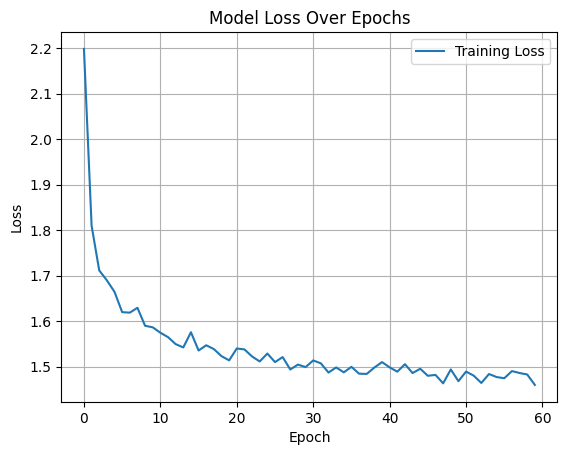

In [26]:
combined_loss = history.history['loss'] + new_history.history['loss']
plt.plot(combined_loss, label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
intermediate_layer = model.layers[-3].output  # -1 is Lambda, -2 is Dense(128), -3 is Dense(256)

# Create a new encoder model
encoder = Model(inputs=model.input, outputs=intermediate_layer)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 24,059,136 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
def build_classifier(encoder, num_classes, train_encoder=False):
    encoder.trainable = train_encoder  # freeze if False

    inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
    x = encoder(inputs, training=train_encoder)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

num_classes = len(class_names)  # class_names from earlier
classifier_model = build_classifier(encoder, num_classes, train_encoder=False)
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 256)                 │      24,112,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,180,871 (92.24 MB)

 Trainable params: 68,103 (266.03 KB)

 Non-trainable params: 24,112,768 (91.98 MB)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# # Define path to save the best model
# checkpoint_path = "best_classifier_model.keras"

# # Create the callback
# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_accuracy',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='max',
#     verbose=1
# )
# Train with the callback
history = classifier_model.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=25
)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 725ms/step - accuracy: 0.5557 - loss: 1.3247 - val_accuracy: 0.9923 - val_loss: 0.2034
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 617ms/step - accuracy: 0.9793 - loss: 0.1578 - val_accuracy: 0.9846 - val_loss: 0.1133
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 581ms/step - accuracy: 0.9865 - loss: 0.0912 - val_accuracy: 0.9910 - val_loss: 0.0631
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 610ms/step - accuracy: 0.9886 - loss: 0.0745 - val_accuracy: 0.9949 - val_loss: 0.0439
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 105s 584ms/step - accuracy: 0.9873 - loss: 0.0689 - val_accuracy: 0.9923 - val_loss: 0.0450
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 582ms/step - accuracy: 0.9864 - loss: 0.0584 - val_accuracy: 0.9949 - val_loss: 0.0371
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 113s 586ms/step - accuracy: 0.9863 - loss: 0.0551 - val_accuracy: 0.9936 - val_loss: 0.0332
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 107s 593ms/step - accuracy: 0.9834 - loss: 0.0688 - 

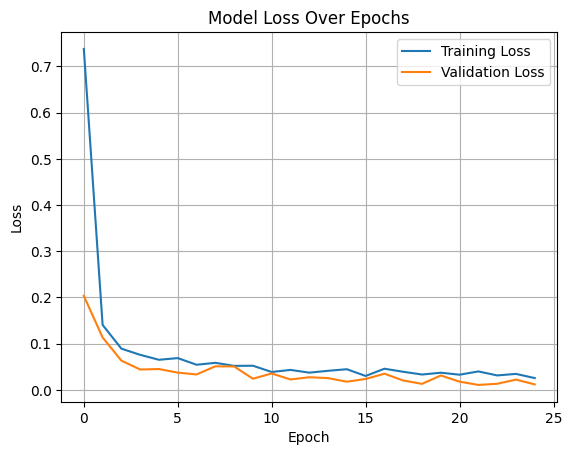

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

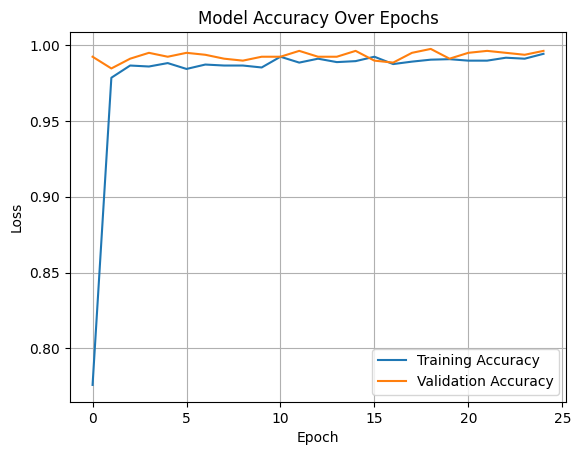

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from tensorflow.keras.models import load_model

best_model = load_model("/kaggle/working/my_model.h5")

In [31]:
val_loss, val_accuracy = best_model.evaluate(val_ds)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 171ms/step - accuracy: 1.0000 - loss: 0.0032
Validation Accuracy: 100.00%
Validation Loss: 0.0024


In [33]:
classifier_model.save("my_model_resnet.h5")

In [35]:
from tensorflow.keras.preprocessing import image
# Constants
IMAGE_FOLDER = "/kaggle/input/openaimer-2025-track1/openaimer-2025-track1/OpenAImer2025_Image_Classification/OpenAImer/test"
OUTPUT_CSV = "predictions_resnet.csv"

# === PREPROCESS FUNCTION ===
def preprocess_image(img_path, target_size=(HEIGHT, WIDTH)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# === GET IMAGE FILES ===
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')]

# Store results
image_ids = []
predictions = []

# Process in batches
for i in tqdm(range(0, len(image_files), BATCH_SIZE)):
    batch_files = image_files[i:i+BATCH_SIZE]
    
    # Preprocess all images in the batch
    batch_images = []
    batch_ids = []

    for img_file in batch_files:
        img_id = img_file.replace("YehKarkeDikhaao", "").replace(".jpg", "")
        img_path = os.path.join(IMAGE_FOLDER, img_file)
        
        img_array = preprocess_image(img_path)
        batch_images.append(img_array)
        batch_ids.append(img_id)

    batch_images_np = np.array(batch_images)
    
    # Predict batch
    batch_preds = classifier_model.predict(batch_images_np)
    batch_labels = np.argmax(batch_preds, axis=1)

    # Collect predictions
    image_ids.extend(batch_ids)
    predictions.extend([class_names[label] for label in batch_labels])

  0%|          | 0/44 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  2%|▏         | 1/44 [00:04<03:33,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 2/44 [00:05<01:37,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 3/44 [00:05<00:59,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 4/44 [00:06<00:41,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 5/44 [00:06<00:32,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 6/44 [00:07<00:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 7/44 [00:07<00:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 8/44 [00:08<00:19,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 9/44 [00:08<00:18,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 10/44 [00:08<00:16,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 11/44 [00:09<00:15,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|██▋       | 12/44 [00:09<00:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 13/44 [00:10<00:14,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 14/44 [00:10<00:13,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 15/44 [00:11<00:12,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▋      | 16/44 [00:11<00:12,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▊      | 17/44 [00:12<00:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 18/44 [00:12<00:11,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 19/44 [00:12<00:11,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▌     | 20/44 [00:13<00:10,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 21/44 [00:13<00:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 22/44 [00:14<00:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 23/44 [00:14<00:10,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▍    | 24/44 [00:15<00:09,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 25/44 [00:15<00:09,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 26/44 [00:16<00:08,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████▏   | 27/44 [00:16<00:07,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 28/44 [00:17<00:07,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 29/44 [00:17<00:06,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 30/44 [00:18<00:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 31/44 [00:18<00:06,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 73%|███████▎  | 32/44 [00:19<00:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▌  | 33/44 [00:19<00:04,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 34/44 [00:19<00:04,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 35/44 [00:20<00:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 36/44 [00:20<00:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 37/44 [00:21<00:03,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▋ | 38/44 [00:21<00:02,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▊ | 39/44 [00:22<00:02,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 40/44 [00:22<00:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 41/44 [00:22<00:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 95%|█████████▌| 42/44 [00:23<00:00,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 43/44 [00:23<00:00,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


In [36]:
df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})

# === SAVE TO CSV ===
df.to_csv(OUTPUT_CSV, index=False)

print(f"Predictions saved to {OUTPUT_CSV}")

Predictions saved to predictions_resnet.csv


In [37]:
df.head()

,id,label
0,63392,cat
1,60822,cat
2,287801,car
3,385827,bus
4,175511,dog
